In [0]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, tree
from sklearn.pipeline import Pipeline

### Sentiment Analysis Functions

In [0]:
vaderAnalyzer = SentimentIntensityAnalyzer()

def analyzeVader(line):
  if not line:
    return None
  vs = vaderAnalyzer.polarity_scores(line)
  return T.Row('neg', 'neu', 'nos', 'comp')(vs['neg'], vs['neu'], vs['pos'], vs['compound'])

vaderSchema = T.StructType([
    T.StructField("neg", T.DoubleType(), False),
    T.StructField("neu", T.DoubleType(), False),
    T.StructField("pos", T.DoubleType(), False),
    T.StructField("comp", T.DoubleType(), False)])

def analyzeTextBlob(line):
  if not line:
    return None
  analysis = TextBlob(line).sentiment
  return T.Row('polarity', 'subjectivity')(analysis[0], analysis[1])

tbSchema = T.StructType([
    T.StructField("polarity", T.DoubleType(), False),
    T.StructField("subjectivity", T.DoubleType(), False)])

def voteForTrump(query, comp):
  res = False
  if comp > 0.05:
    res = True
  elif comp <= -0.05:
    res = False
  if query != 'trump':
    res = not res
  return res

vader_udf = F.udf(analyzeVader, vaderSchema)
textblob_udf = F.udf(analyzeTextBlob, tbSchema)
vote_udf = F.udf(voteForTrump)

### Plot Function

In [0]:
def plot(grid):
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

# 2016 data

In [0]:
clinton1 = spark.table("clinton1_2016")
clinton2 = spark.table("clinton2_2016")
trump2016 = spark.table("trump_2016")

df = clinton1.union(clinton2)
df = df.union(trump2016)
display(df)

index,query,submission_type,id,parent_id,author,subreddit,title,url,body,created_utc,created_hr_date,depth,upvotes,downvotes
0.0,clinton,POST,50lnc4,(none),(none),politics,Donald Trump’s Immigration Proposals May Have a Secret Fan: Hillary Clinton,http://www.thedailybeast.com/articles/2016/09/01/donald-trump-s-immigration-proposals-may-have-a-secret-fan-hillary-clinton.html,[deleted],null,2016-09-01T01:15:14.000+0000,null,0.0,0.0
1.0,clinton,CMNT,d751t0i,50lnc4,AutoModerator,politics,(none),(none),"\n[As a reminder, this subreddit is for civil discussion.](https://www.reddit.com/r/politics/wiki/rulesandregs#wiki_please_be_civil)\n\n* Do not call other users trolls, morons, children, or anything else clever you may think of. [Personal attacks, whether explicit or implicit, are not permitted.](https://www.reddit.com/r/politics/wiki/rulesandregs#wiki_no_personal_attacks)\n\n* Do not accuse other users of being shills. If you believe that a user is a shill, the proper conduct is to report the user or send us a modmail.\n\n* In general, don't be a jerk. Don't bait people, don't use hate speech, etc. Attack ideas, not users.\n\n* Do not downvote comments because you disagree with them, and be willing to upvote quality comments whether you agree with the opinions held or not.\n\nIncivility results in escalating bans from the subreddit. If you see uncivil comments, please report them and do not reply with incivility of your own.\n\n***\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/politics) if you have any questions or concerns.*",null,2016-09-01T01:15:15.000+0000,0.0,1.0,0.0
2.0,clinton,CMNT,d753obg,50lnc4,shaking_head,politics,(none),(none),"I'm assuming the CTR is going to downvote this until the bot removal condition kicks in. But the article has a point, she did vote for a wall in 2006: https://www.govtrack.us/congress/bills/109/hr6061/summary\n\nLet's also remember that Obama and the State Department (when Hillary was Secretary of State in 2011) stopped processing refugee requests from Iraqis for six months in order to review and revamp security screening procedures.",null,2016-09-01T02:37:03.000+0000,0.0,3.0,0.0
3.0,clinton,CMNT,d7520n3,50lnc4,(none),politics,(none),(none),Because this is killing Trump,null,2016-09-01T01:23:38.000+0000,0.0,0.0,0.0
4.0,clinton,CMNT,d752e6e,50lnc4,(none),politics,(none),(none),Well yeah! They're going to get her elected.,null,2016-09-01T01:39:02.000+0000,0.0,0.0,0.0
5.0,clinton,CMNT,d753syr,50lnc4,alexanderwales,politics,(none),(none),I don't know why anyone *would* downvote this. Clinton doesn't advocate for open borders or unlimited immigration. She's not the immigrant-loving caricature that Donald Trump paints her as.,null,2016-09-01T02:43:25.000+0000,1.0,4.0,0.0
6.0,clinton,CMNT,d7579wl,50lnc4,overthrow23,politics,(none),(none),"Is that what's happening?\n\nIt certainly seems like a group is actively camping in the ""new"" queue, doing their damnedest to make sure that stories critical of a certain candidate are buried.\n\nNot going to say which candidate, but *coincidentally* Reddit changed the way their users votes are counted, also to the benefit that one certain candidate.\n\n\nAnd now there's an automated message warning users not to point these things out.",null,2016-09-01T06:05:56.000+0000,1.0,2.0,0.0
7.0,clinton,CMNT,d753y3y,50lnc4,shaking_head,politics,(none),(none),"You're absolutely right, but it has reached 36% upvote and will hover until bot removal. You're also right that she isn't an open border lover, then or now. But battle lines have been drawn on candidates and any somewhat agreement or ambiguity between policies on this sub and others hasn't been tolerated during this election cycle as it takes away the theme of literally Hitler vs infallible Angel (depending on which side people are on).",null,2016-09-01T02:50:36.000+0000,2.0,2.0,0.0
8.0,clinton,CMNT,d75ceo3,50lnc4,shaking_head,poli

In [0]:
print(df.printSchema())
print(df.count())

root
-- index: double (nullable = true)
-- query: string (nullable = true)
-- submission_type: string (nullable = true)
-- id: string (nullable = true)
-- parent_id: string (nullable = true)
-- author: string (nullable = true)
-- subreddit: string (nullable = true)
-- title: string (nullable = true)
-- url: string (nullable = true)
-- body: string (nullable = true)
-- created_utc: timestamp (nullable = true)
-- created_hr_date: timestamp (nullable = true)
-- depth: double (nullable = true)
-- upvotes: double (nullable = true)
-- downvotes: double (nullable = true)

None
568587

## Processing 2016 dataset

In [0]:
df = df \
      .filter(~(F.col("author").contains("Moderator"))) \
      .filter(~(F.col("author").contains("Bot"))) \
      .filter(~(F.col("author").contains("(none)"))) \
      .filter(F.col("author").isNotNull()) \
      .filter(F.col("index").isNotNull()) 

df = df \
      .filter(F.col("body").isNotNull()) \
      .filter(F.col("upvotes").isNotNull()) \
      .filter(F.col("downvotes").isNotNull())

df = df.dropDuplicates(['id', 'parent_id', 'author'])

df = df.withColumn("isTrump", F.when(F.col('query') == 'trump', True).otherwise(False))

print(df.count())
print(df.show())

375907
+------+-------+---------------+-------+---------+-------------------+---------+------+------+--------------------+-----------+-------------------+-----+-------+---------+-------+
 index| query|submission_type| id|parent_id| author|subreddit| title| url| body|created_utc| created_hr_date|depth|upvotes|downvotes|isTrump|
+------+-------+---------------+-------+---------+-------------------+---------+------+------+--------------------+-----------+-------------------+-----+-------+---------+-------+
 23.0|clinton| CMNT|d752i47| 50lgxs| allahfalsegod| politics|(none)|(none)|I miss snowden, r...| null|2016-09-01 01:43:42| 0.0| 2.0| 0.0| false|
 48.0|clinton| CMNT|d75371j| 50lgxs| ChipStarfield| politics|(none)|(none)|What information ...| null|2016-09-01 02:14:20| 3.0| 0.0| 0.0| false|
 105.0| trump| CMNT|d75390i| 50lq8y| thegoodvibe| politics|(none)|(none)|Which even then i...| null|2016-09-01 02:16:49| 2.0| -1.0| 0.0| true|
 102.0| trump| CMNT|d75407o| 50lq8y| AgoraiosBum| politics|(none)|(none)|Unless you're an ...| null|2016-09-01 02:53:37| 2.0| 4.0| 0.0| true|
 20.0| trump| CMNT|d7549hc| 50lrye|reluctant_qualifier| politics|(none)|(none)|This either comes...| null|2016-09-01 03:07:00| 0.0| 2.0| 0.0| true|
 34.0|clinton| CMNT|d754mj3| 50lgxs| mcotter12| politics|(none)|(none)|Lets get somethin...| null|2016-09-01 03:26:20| 1.0| 0.0| 0.0| false|
 35.0|clinton| CMNT|d7559dh| 50m0s6| snowballs884| politics|(none)|(none)|not just a lozeng...| null|2016-09-01 04:02:00| 1.0| 8.0| 0.0| false|
 7.0| trump| CMNT|d757p30| 50ls8a| wavescrashover| politics|(none)|(none)|Didn't read the a...| null|2016-09-01 06:29:58| 1.0| 1.0| 0.0| true|
 31.0| trump| CMNT|d757uzd| 50lrye| wavescrashover| politics|(none)|(none)|But who is to say...| null|2016-09-01 06:38:53| 1.0| 2.0| 0.0| true|
 73.0| trump| CMNT|d7586pr| 50lr0h| wavescrashover| politics|(none)|(none)|> The funny thing...| null|2016-09-01 06:56:12| 1.0| 2.0| 0.0| true|
 215.0|clinton| CMNT|d758waj| 50mglk| Ximitar| politics|(none)|(none)|But when Trump "t...| null|2016-09-01 07:31:46| 2.0| -4.0| 0.0| false|
1676.0| trump| CMNT|d758x49| 50mnyi| janzeera| politics|(none)|(none)|Every photo/video...| null|2016-09-01 07:32:47| 1.0| 1.0| 0.0| true|
 467.0| trump| CMNT|d759qy0| 50ms5g| DrScientist812| politics|(none)|(none)|No one calls him ...| null|2016-09-01 08:06:57| 2.0| -1.0| 0.0| true|
 3.0|clinton| CMNT|d759riq| 50mswc| DebussySIMiami| politics|(none)|(none)|He promised to de...| null|2016-09-01 08:07:34| 0.0| 14.0| 0.0| false|
 113.0|clinton| CMNT|d75a1u9| 50mp4p| aledlewis| politics|(none)|(none)|Ah! Legit. Thanks...| null|2016-09-01 08:17:53| 2.0| 0.0| 0.0| false|
 97.0|clinton| CMNT|d75a4u5| 50mp4p| buzzlightbeard115| politics|(none)|(none)|Yeah, the Clinton...| null|2016-09-01 08:20:46| 1.0| 7.0| 0.0| false|
 30.0|clinton| CMNT|d75ambo| 50mswc| Dadalot| politics|(none)|(none)|[Um, it's not a "...| null|2016-09-01 08:37:12| 2.0| -2.0| 0.0| false|
1092.0| trump| CMNT|d75bc9l| 50ms5g| TRogow| politics|(none)|(none)| Won't happen.| null|2016-09-01 08:59:49| 3.0| 17.0| 0.0| true|
1488.0| trump| CMNT|d75ceej| 50ms5g| schabadoo| politics|(none)|(none)|The woman who's b...| null|2016-09-01 09:30:09| 5.0| 22.0| 0.0| true|
 33.0|clinton| CMNT|d75cjp3| 50n5op| treerat| politics|(none)|(none)|Assange seems to ...| null|2016-09-01 09:34:10| 0.0| -1.0| 0.0| false|
+------+-------+---------------+-------+---------+-------------------+---------+------+------+--------------------+-----------+-------------------+-----+-------+---------+-------+
only showing top 20 rows

None

### Extracting Sentiment on 2016 data

In [0]:
dfSentiment = df \
              .withColumn("vader", vader_udf(F.col('body'))) \
              .withColumn("textblob", textblob_udf(F.col('body'))) \
              .withColumn('vaderNeg', F.col('vader.neg')) \
              .withColumn('vaderNeu', F.col('vader.neu')) \
              .withColumn('vaderPos', F.col('vader.pos')) \
              .withColumn('vaderComp', F.col('vader.comp')) \
              .withColumn('textblobPolarity', F.col('textblob.polarity')) \
              .withColumn('textblobSubjectivity', F.col('textblob.subjectivity'))

dfSentiment = dfSentiment.drop("vader", "textblob")

dfSentiment = dfSentiment.filter(F.col('vaderNeu') != 1)

dfSentiment = dfSentiment.withColumn("voteForTrump", vote_udf('query', 'vaderComp'))

print(dfSentiment.printSchema())

root
-- index: double (nullable = true)
-- query: string (nullable = true)
-- submission_type: string (nullable = true)
-- id: string (nullable = true)
-- parent_id: string (nullable = true)
-- author: string (nullable = true)
-- subreddit: string (nullable = true)
-- title: string (nullable = true)
-- url: string (nullable = true)
-- body: string (nullable = true)
-- created_utc: timestamp (nullable = true)
-- created_hr_date: timestamp (nullable = true)
-- depth: double (nullable = true)
-- upvotes: double (nullable = true)
-- downvotes: double (nullable = true)
-- isTrump: boolean (nullable = false)
-- vaderNeg: double (nullable = true)
-- vaderNeu: double (nullable = true)
-- vaderPos: double (nullable = true)
-- vaderComp: double (nullable = true)
-- textblobPolarity: double (nullable = true)
-- textblobSubjectivity: double (nullable = true)
-- voteForTrump: string (nullable = true)

None

In [0]:
display(dfSentiment) 

index,query,submission_type,id,parent_id,author,subreddit,title,url,body,created_utc,created_hr_date,depth,upvotes,downvotes,isTrump,vaderNeg,vaderNeu,vaderPos,vaderComp,textblobPolarity,textblobSubjectivity,voteForTrump
23.0,clinton,CMNT,d752i47,50lgxs,allahfalsegod,politics,(none),(none),"I miss snowden, really hope obama pardons him at the 11 hour.",null,2016-09-01T01:43:42.000+0000,0.0,2.0,0.0,false,0.098,0.554,0.348,0.6195,0.2,0.2,false
102.0,trump,CMNT,d75407o,50lq8y,AgoraiosBum,politics,(none),(none),"Unless you're an average Joe that just got flooded in Louisiana or hit with a hurricane in New Jersey or anywhere else with strange weather-related disasters. Those are two 'safe' states, but it sure matters down in Florida. \n\nTrump loses Florida...he doesn't win (or, rather, it goes to super long shot)",null,2016-09-01T02:53:37.000+0000,2.0,4.0,0.0,true,0.148,0.673,0.179,0.4482,0.1564141414141414,0.42489898989898983,true
20.0,trump,CMNT,d7549hc,50lrye,reluctant_qualifier,politics,(none),(none),"This either comes down to one of three things:\n\n* A pop quiz like the US citizenship test (http://www.cnn.com/2016/06/30/us/4th-of-july-quiz-us-citizenship/)\n\n* Meaningless checkboxes like the Visa security questions (http://www.immihelp.com/visas/ds-160-form/security-background-information.html#security-information)\n\n* Something like the McCarran act, which was deemed to be constitutional (https://en.wikipedia.org/wiki/McCarran_Internal_Security_Act).\n\nThe idea that you can spot people's bad intentions by giving them an exam is absurd. Effective background checking needs to be (and is) performed on targeted individuals - expanding this approach to *everyone* coming into the country will just make it less effective.",null,2016-09-01T03:07:00.000+0000,0.0,2.0,0.0,true,0.066,0.745,0.188,0.8692,-0.11746031746031747,0.6603174603174604,true
34.0,clinton,CMNT,d754mj3,50lgxs,mcotter12,politics,(none),(none),Lets get something straight. Trump is a joke who is never going to win in November. Leaks about him aren't nearly as important as leaks about Clinton.,null,2016-09-01T03:26:20.000+0000,1.0,0.0,0.0,false,0.147,0.724,0.129,-0.1441,0.4666666666666666,0.6,true
35.0,clinton,CMNT,d7559dh,50m0s6,snowballs884,politics,(none),(none),"not just a lozenge...a ""medical lozenge""...thanks for the laugh...",null,2016-09-01T04:02:00.000+0000,1.0,8.0,0.0,false,0.0,0.69,0.31,0.5574,0.15,0.05,false
7.0,trump,CMNT,d757p30,50ls8a,wavescrashover,politics,(none),(none),"Didn't read the article so not sure what ""proof"" it has to back up the headline. However, I will say that I was browsing Twitter yesterday for Trump related tweets and saw a lot of angry/hateful posts from people in Mexico, who were so upset that 1) their President invited Trump 2) that Trump was actually coming. I saw some talk about seeing protests, though I'm not quite sure where in relation to where Trump was visiting.",null,2016-09-01T06:29:58.000+0000,1.0,1.0,0.0,true,0.117,0.883,0.0,-0.8265,0.05,0.45555555555555555,false
31.0,trump,CMNT,d757uzd,50lrye,wavescrashover,politics,(none),(none),"But who is to say what the values of our citizens/country are? If this election has taught anyone anything, it's that staunch Trump supporters' values are drastically different from the values of staunch Clinton supporters. And there's a million others in between. But living in America, we're granted the right to hold these different values. So now all of a sudden we're supposed to come up with a checklist of ideals that are a requirement to become one of us? Are current US citizens going to be asked to conform and hold the ideals that get placed on this test? Asked to abandon any values we hold that aren't on the checklist?\n\nHow does that encompass freedom or being an American?",null,2016-09-01T06:38:53.000+0000,1.0,2.0,0.0,true,0.026,0.715,0.259,0.9884,0.047619047619047616,0.4392857142857143,true
73.0,trump,CMNT,d7586pr,50lr0h,wavescrashover,politics,(none),(none),"> The funny thing 

### Training/Prediction on 2016 data

In [0]:
dfpd16 = dfSentiment.toPandas()

In [0]:
X16 = dfpd16[[
#           'vaderNeg', 
#           'vaderNeu', 
#           'vaderPos', 
          'vaderComp',
          'textblobPolarity', 
          'textblobSubjectivity',
          'upvotes'
         ]]
# y16 = dfpd16['isTrump']
# y16 = dfpd[['query']]
y16 = dfpd16['voteForTrump']

# X16 = dfSentiment.select('upvotes', 'downvotes', 'vaderComp', 'textblobPolarity', 'textblobSubjectivity').toPandas()
# y16 = dfSentiment.select('query').toPandas()

print(X16.shape, y16.shape)
print(X16)
print(y16)

(292517, 4) (292517,)
 vaderComp textblobPolarity textblobSubjectivity upvotes
0 0.6195 0.200000 0.200000 2.0
1 0.4482 0.156414 0.424899 4.0
2 0.8692 -0.117460 0.660317 2.0
3 -0.1441 0.466667 0.600000 0.0
4 0.5574 0.150000 0.050000 8.0
... ... ... ... ...
292512 -0.2481 0.000000 0.000000 1.0
292513 0.9565 0.600000 0.596296 1.0
292514 0.0067 0.264286 0.557143 1.0
292515 0.6124 0.050000 0.700000 0.0
292516 -0.2500 0.000000 0.000000 1.0

[292517 rows x 4 columns]
0 false
1 true
2 true
3 true
4 false
 ... 
292512 true
292513 false
292514 false
292515 true
292516 true
Name: voteForTrump, Length: 292517, dtype: object

In [0]:
X16 = preprocessing.scale(X16)
X16_train, X16_test, y16_train, y16_test = train_test_split(X16, y16, test_size=0.2)

In [0]:
param_grid = dict()
clf = LogisticRegression()
clf = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X16_train, y16_train)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X16_test)
print(p_best, collections.Counter(p_best))
print(result.score(X16_test, y16_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 5 out of 5 | elapsed: 15.9s finished
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
 fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
 max_iter=100, multi_class='auto', n_jobs=None,
 penalty='l2', random_state=None, refit=True, scoring=None,
 solver='lbfgs', tol=0.0001, verbose=0)
0.5157576895710488
[ True False False ... True False False] Counter({False: 41277, True: 17227})
0.513640092985095

In [0]:
param_grid = dict()
clf = tree.DecisionTreeClassifier()
clf = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X16_train, y16_train)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X16_test)
print(p_best, collections.Counter(p_best))
print(result.score(X16_test, y16_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 5 out of 5 | elapsed: 6.3s finished
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
 max_depth=None, max_features=None, max_leaf_nodes=None,
 min_impurity_decrease=0.0, min_impurity_split=None,
 min_samples_leaf=1, min_samples_split=2,
 min_weight_fraction_leaf=0.0, presort='deprecated',
 random_state=None, splitter='best')
0.507467542621001
[False False False ... False False True] Counter({False: 30385, True: 28119})
0.5088882811431698

In [0]:
param_grid = dict()
clf = KNeighborsClassifier()
clf = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X16_train, y16_train)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X16_test)
print(p_best, collections.Counter(p_best))
print(result.score(X16_test, y16_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 5 out of 5 | elapsed: 1.1min finished
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
 weights='uniform')
0.5083050941258237
[ True False False ... False True True] Counter({False: 29949, True: 28555})
0.5103582661014632

# 2020 Data

In [0]:
trump2020 = spark.table("trump_2020")
biden2020 = spark.table("biden_2020")

df20 = biden2020.union(trump2020)

df20 = df20 \
      .filter(~(F.col("author").contains("Moderator"))) \
      .filter(~(F.col("author").contains("Bot"))) \
      .filter(~(F.col("author").contains("(none)"))) \
      .filter(F.col("author").isNotNull()) \
      .filter(F.col("index").isNotNull()) \

df20 = df20.filter(F.col("body").isNotNull())

df20 = df20 \
      .filter(F.col("upvotes").isNotNull()) \
      .filter(F.col("downvotes").isNotNull())

df20 = df20.dropDuplicates(['id', 'parent_id', 'author'])
df20 = df20.withColumn("isTrump", F.when(F.col('query') == 'trump', True).otherwise(False))

### Extracting Sentiment on 2020 data

In [0]:
dfSentiment20 = df20 \
              .withColumn("vader", vader_udf(F.col('body'))) \
              .withColumn("textblob", textblob_udf(F.col('body'))) \
              .withColumn('vaderNeg', F.col('vader.neg')) \
              .withColumn('vaderNeu', F.col('vader.neu')) \
              .withColumn('vaderPos', F.col('vader.pos')) \
              .withColumn('vaderComp', F.col('vader.comp')) \
              .withColumn('textblobPolarity', F.col('textblob.polarity')) \
              .withColumn('textblobSubjectivity', F.col('textblob.subjectivity'))

dfSentiment20 = dfSentiment20.drop("vader", "textblob")

dfSentiment20 = dfSentiment20.filter(F.col('vaderNeu') != 1)

dfSentiment20 = dfSentiment20.withColumn("voteForTrump", vote_udf('query', 'vaderComp'))

print(dfSentiment20.count())
print(dfSentiment20.show())

461692
+-----+-----+---------------+-------+---------+------------------+---------+------+------+--------------------+-----------+-------------------+-----+-------+---------+-------+--------+--------+--------+---------+--------------------+--------------------+------------+
index|query|submission_type| id|parent_id| author|subreddit| title| url| body|created_utc| created_hr_date|depth|upvotes|downvotes|isTrump|vaderNeg|vaderNeu|vaderPos|vaderComp| textblobPolarity|textblobSubjectivity|voteForTrump|
+-----+-----+---------------+-------+---------+------------------+---------+------+------+--------------------+-----------+-------------------+-----+-------+---------+-------+--------+--------+--------+---------+--------------------+--------------------+------------+
205.0|biden| CMNT|g3k01f5| ikdi9a| crudedrawer| politics|(none)|(none)|Sure, trump can b...| null|2020-09-01 00:37:36| 1.0| 14.0| 0.0| false| 0.119| 0.786| 0.095| -0.2023| 0.175| 0.6444444444444444| true|
 81.0|trump| CMNT|g3k33a8| ikeblg| FionnMacCoolie| politics|(none)|(none)|Wow, I can’t beli...| null|2020-09-01 01:16:48| 0.0| 1.0| 0.0| true| 0.091| 0.743| 0.166| 0.4033|0.011666666666666667| 0.4316666666666667| true|
 96.0|trump| CMNT|g3k5esp| ikeag5| goatfishbat| politics|(none)|(none)|Yep I’m sat here,...| null|2020-09-01 01:49:00| 0.0| 3.0| 0.0| true| 0.0| 0.55| 0.45| 0.5994| 0.0| 0.5| true|
 20.0|trump| CMNT|g3k5m87| ikeo4b| Darzanak| politics|(none)|(none)|“Companies, he sa...| null|2020-09-01 01:51:53| 0.0| 7.0| 0.0| true| 0.128| 0.674| 0.197| 0.6486| -0.16875| 0.63125| true|
113.0|biden| CMNT|g3k6zdh| ikdt8k|Thats_a_happy_tree| politics|(none)|(none)|That's what peopl...| null|2020-09-01 02:12:18| 2.0| -15.0| 0.0| false| 0.0| 0.727| 0.273| 0.7827| 0.25625| 0.31666666666666665| false|
 28.0|trump| CMNT|g3k7zrk| ikeo4b| BobsBarker12| politics|(none)|(none)|Remember this eve...| null|2020-09-01 02:27:47| 0.0| 2.0| 0.0| true| 0.08| 0.805| 0.115| 0.1783| 0.13333333333333333| 0.25| true|
 9.0|biden| CMNT|g3k8epx| ikevn2| jimmydean885| politics|(none)|(none)|Jesus...you know ...| null|2020-09-01 02:34:11| 0.0| 22.0| 0.0| false| 0.163| 0.837| 0.0| -0.6868|-0.07500000000000001| 0.19166666666666665| true|
 53.0|biden| CMNT|g3k8qz4| ikfdhw| AmbivalentAsshole| politics|(none)|(none)|It's like someone...| null|2020-09-01 02:39:32| 0.0| 2.0| 0.0| false| 0.274| 0.513| 0.214| -0.1779| -0.625| 1.0| true|
 31.0|trump| CMNT|g3k9ecj| ikeo4b| johntwoods| politics|(none)|(none)|But, Black Lives ...| null|2020-09-01 02:50:03| 0.0| 2.0| 0.0| true| 0.125| 0.802| 0.073| -0.217| -0.1597222222222222| 0.7069444444444445| false|
 57.0|biden| CMNT|g3ka1le| ikfdhw| kthulhu666| politics|(none)|(none)|Prince of all lie...| null|2020-09-01 03:00:28| 0.0| 1.0| 0.0| false| 0.318| 0.682| 0.0| -0.4215| 0.0| 0.0| true|
 51.0|trump| CMNT|g3ka9gm| ikeo4b| McKoijion| politics|(none)|(none)|Well, kicking Tru...| null|2020-09-01 03:04:02| 2.0| 2.0| 0.0| true| 0.044| 0.856| 0.1| 0.5493| 0.32666666666666666| 0.5611538461538461| true|
 73.0|biden| CMNT|g3kat4z| ikfdhw| hdean173| politics|(none)|(none)|It WAS a dog whis...| null|2020-09-01 03:13:16| 2.0| 5.0| 0.0| false| 0.34| 0.66| 0.0| -0.9468| -0.45| 0.75| true|
122.0|trump| CMNT|g3kboa4| ikfu4q| Azlend| politics|(none)|(none)|Then every person...| null|2020-09-01 03:28:03| 0.0| 12.0| 0.0| true| 0.238| 0.696| 0.067| -0.7096| 0.07619047619047618| 0.5678571428571428| false|
 33.0|biden| CMNT|g3kdfbd| ikfxwx| agk927| politics|(none)|(none)|So hes not gonna ...| null|2020-09-01 03:59:04| 2.0| -2.0| 0.0| false| 0.434| 0.566| 0.0| -0.4717| 0.8| 0.4| true|
 25.0|trump| CMNT|g3kdjeg| ikg7pe| BMynuSS| politics|(none)|(none)|She knows how stu...| null|2020-09-01 04:01:04| 0.0| 50.0| 0.0| true| 0.208| 0.686| 0.106| -0.4497| -0.475| 0.6| false|
 3.0|biden| CMNT|g3ke2lj| ikg8tw| BMynuSS| politics|(none)|(none)|You would think t...| null|2020-09-01 04:10:47| 0.0| 5.0| 0.0| false| 0.19| 0.81| 0.0| -0.6908| -0.05| 0.3625| true|
 28.0|trump| CMNT|g3keq0n| ikg7pe| AgentBro

### Training/Prediction on 2020 data

In [0]:
dfpd20 = dfSentiment20.toPandas()

In [0]:
X20 = dfpd20[[
#           'vaderNeg', 
#           'vaderNeu', 
#           'vaderPos', 
          'vaderComp',
          'textblobPolarity', 
          'textblobSubjectivity',
          'upvotes'
         ]]
# y20 = dfpd20['isTrump']
# y = dfpd[['query']]
y20 = dfpd20['voteForTrump']

# X = dfSentiment.select('upvotes', 'downvotes', 'vaderComp', 'textblobPolarity', 'textblobSubjectivity').toPandas()
# y = dfSentiment.select('query').toPandas()

print(X20.shape, y20.shape)
print(X20)
print(y20)

(461692, 4) (461692,)
 vaderComp textblobPolarity textblobSubjectivity upvotes
0 -0.2023 0.175000 0.644444 14.0
1 0.4033 0.011667 0.431667 1.0
2 0.5994 0.000000 0.500000 3.0
3 0.6486 -0.168750 0.631250 7.0
4 0.7827 0.256250 0.316667 -15.0
... ... ... ... ...
461687 0.8503 0.150000 0.516667 1.0
461688 0.5231 0.034425 0.329563 1.0
461689 -0.5161 0.090568 0.585806 1.0
461690 -0.0080 0.012500 0.447222 1.0
461691 0.9545 0.416667 0.610317 1.0

[461692 rows x 4 columns]
0 true
1 true
2 true
3 true
4 false
 ... 
461687 true
461688 false
461689 true
461690 false
461691 true
Name: voteForTrump, Length: 461692, dtype: object

In [0]:
X20 = preprocessing.scale(X20)
X20_train, X20_test, y20_train, y20_test = train_test_split(X20, y20, test_size=0.3)

In [0]:
param_grid = dict()
clf = LogisticRegression()
clf = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X20_train, y20_train)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X20_test)
print(p_best, collections.Counter(p_best))
print(result.score(X20_test, y20_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 5 out of 5 | elapsed: 25.1s finished
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
 fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
 max_iter=100, multi_class='auto', n_jobs=None,
 penalty='l2', random_state=None, refit=True, scoring=None,
 solver='lbfgs', tol=0.0001, verbose=0)
0.5286678800778098
['false' 'false' 'false' ... 'false' 'false' 'false'] Counter({'false': 136899, 'true': 1609})
0.5286265053282121

In [0]:
param_grid = dict()
clf = tree.DecisionTreeClassifier()
clf = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X20_train, y20_train)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X20_test)
print(p_best, collections.Counter(p_best))
print(result.score(X20_test, y20_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 5 out of 5 | elapsed: 14.1s finished
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
 max_depth=None, max_features=None, max_leaf_nodes=None,
 min_impurity_decrease=0.0, min_impurity_split=None,
 min_samples_leaf=1, min_samples_split=2,
 min_weight_fraction_leaf=0.0, presort='deprecated',
 random_state=None, splitter='best')
0.5108390214860921
['false' 'false' 'false' ... 'true' 'false' 'true'] Counter({'false': 77205, 'true': 61303})
0.51306061743726

In [0]:
param_grid = dict()
clf = KNeighborsClassifier()
clf = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X20_train, y20_train)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X20_test)
print(p_best, collections.Counter(p_best))
print(result.score(X20_test, y20_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 5 out of 5 | elapsed: 1.8min finished
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
 weights='uniform')
0.5134629104741226
['false' 'true' 'false' ... 'true' 'true' 'true'] Counter({'false': 76772, 'true': 61736})
0.5156669650850493

### Training on 2016 and Predicting on 2020

In [0]:
param_grid = dict()
clf = LogisticRegression()
clf = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X16, y16)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X20)
print(p_best, collections.Counter(p_best))
print(result.score(X20, y20))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 10 out of 10 | elapsed: 15.6s finished
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
 intercept_scaling=1, l1_ratio=None, max_iter=100,
 multi_class='auto', n_jobs=None, penalty='l2',
 random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
 warm_start=False)
0.5121821938059804
['false' 'false' 'false' ... 'false' 'false' 'false'] Counter({'false': 408437, 'true': 53255})
0.5264267087149008

In [0]:
param_grid = dict()
clf = tree.DecisionTreeClassifier()
clf = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X16, y16)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X20)
print(p_best, collections.Counter(p_best))
print(result.score(X20, y20))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 10 out of 10 | elapsed: 27.0s finished
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
 max_depth=None, max_features=None, max_leaf_nodes=None,
 min_impurity_decrease=0.0, min_impurity_split=None,
 min_samples_leaf=1, min_samples_split=2,
 min_weight_fraction_leaf=0.0, presort='deprecated',
 random_state=None, splitter='best')
0.5075431447427424
['false' 'true' 'true' ... 'false' 'true' 'false'] Counter({'false': 243947, 'true': 217745})
0.5033723781222114

In [0]:
param_grid = dict()
clf = KNeighborsClassifier()
clf = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X16, y16)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X20)
print(p_best, collections.Counter(p_best))
print(result.score(X20, y20))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 10 out of 10 | elapsed: 3.2min finished
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
 weights='uniform')
0.5091054544561742
['true' 'false' 'false' ... 'true' 'true' 'true'] Counter({'false': 238135, 'true': 223557})
0.5031514516170954

### Hyperparameter Tuning

In [0]:
param_grid = dict(fit_intercept=[True,False],solver=['newton-cg', 'lbfgs', 'saga'],class_weight=['balanced','None'])
clf = LogisticRegression()
clf = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X16, y16)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X20)
print(p_best, collections.Counter(p_best))
print(result.score(X20, y20))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 46 tasks | elapsed: 1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 3.8min finished
LogisticRegression(C=1.0, class_weight='None', dual=False, fit_intercept=True,
 intercept_scaling=1, l1_ratio=None, max_iter=100,
 multi_class='auto', n_jobs=None, penalty='l2',
 random_state=None, solver='saga', tol=0.0001, verbose=0,
 warm_start=False)
0.5121856123756509
['false' 'false' 'false' ... 'false' 'false' 'false'] Counter({'false': 408468, 'true': 53224})
0.5264462022300581

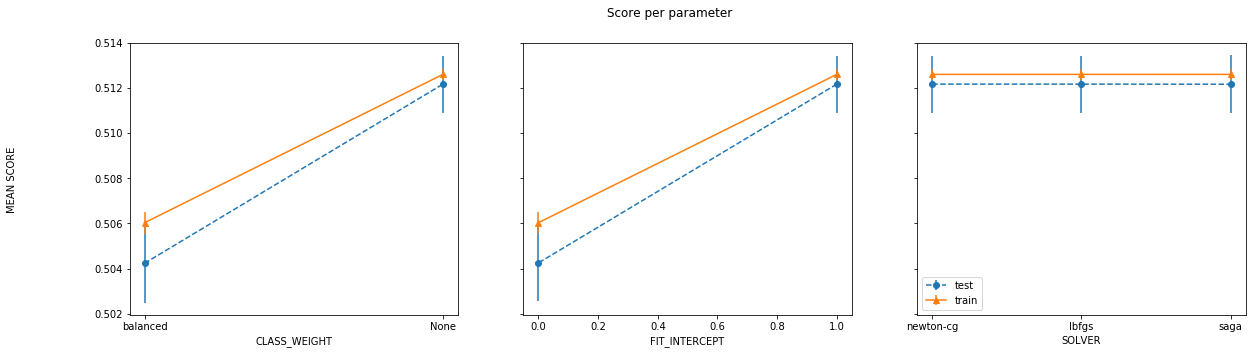

In [0]:
plot(result)

In [0]:
param_grid = dict(criterion=['gini', 'entropy'],min_samples_split=np.linspace(0.001, 0.1, 10, endpoint=True),splitter=['best', 'random'])
clf = tree.DecisionTreeClassifier()
clf = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X16, y16)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X20)
print(p_best, collections.Counter(p_best))
print(result.score(X20, y20))

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 46 tasks | elapsed: 1.3min
[Parallel(n_jobs=-1)]: Done 196 tasks | elapsed: 4.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 10.0min finished
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
 max_depth=None, max_features=None, max_leaf_nodes=None,
 min_impurity_decrease=0.0, min_impurity_split=None,
 min_samples_leaf=1,
 min_samples_split=0.05600000000000001,
 min_weight_fraction_leaf=0.0, presort='deprecated',
 random_state=None, splitter='best')
0.5336989093763511
['true' 'true' 'false' ... 'false' 'false' 'false'] Counter({'false': 291423, 'true': 170269})
0.5107755819897247

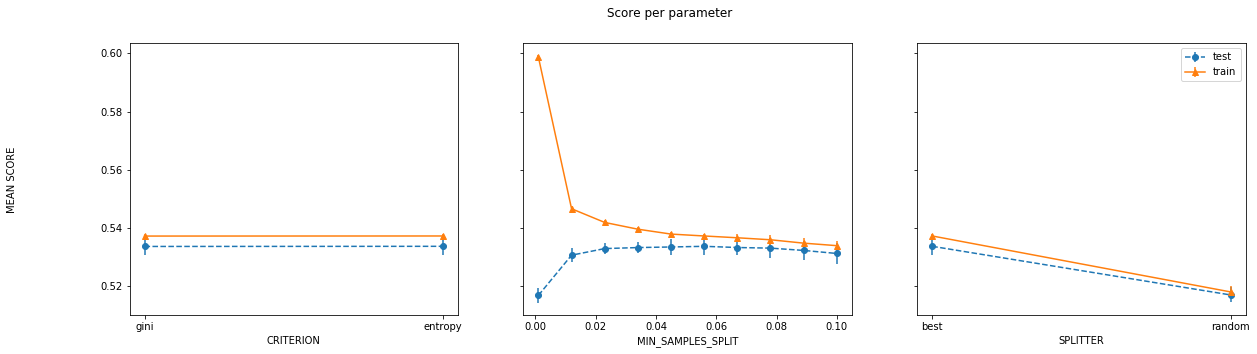

In [0]:
plot(result)

In [0]:
param_grid = dict(n_neighbors=[3,5],weights=['uniform','distance'],leaf_size=[10,30])
clf = KNeighborsClassifier()
clf = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='accuracy', return_train_score=True, verbose=True, n_jobs=-1)
result = clf.fit(X16, y16)
print(result.best_estimator_)
print(result.best_score_)
p_best = result.predict(X20)
print(p_best, collections.Counter(p_best))
print(result.score(X20, y20))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 46 tasks | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 80 out of 80 | elapsed: 18.7min finished
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
 weights='uniform')
0.509816529335867
['false' 'false' 'false' ... 'false' 'true' 'true'] Counter({'false': 237189, 'true': 224503})
0.5017825736638278

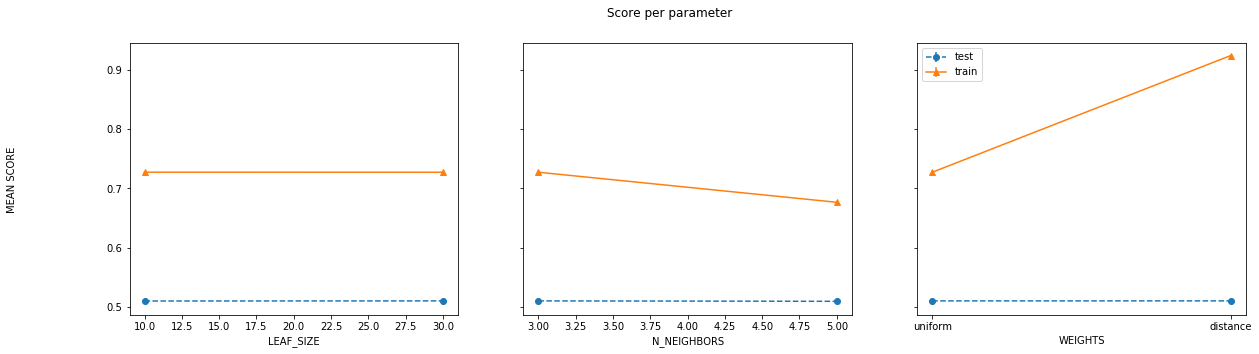

In [0]:
plot(result)